# Introduction

The goal of this short report is to describe the Local Outlier Factor algorithm and to present an interactive data visualization allowing for some hyperparameter tweaking using plotly.

# Useful Resources
- https://jennifer-banks8585.medium.com/how-to-embed-interactive-plotly-visualizations-on-medium-blogs-710209f93bd
- https://docs.datapane.com/reports/embedding-reports-in-social-platforms

Datapane seems better!

- point sizes in plotly: https://stackoverflow.com/questions/47086547/set-marker-size-based-on-coordinate-values-not-pixels-in-plotly-r

# Setup

In [1]:
# Setup
import os
import chart_studio
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
from sklearn.neighbors import LocalOutlierFactor
import plotly.express as px
import plotly.graph_objects as go
import datapane as dp

GREY = '#788995'
BLUE = '#0059ff'
GOLD = '#fdbd28'
GREEN = '#28D9AA'
RED = '#EE5149'
METAL_SUN = '#AD8D40'
DARK_ORCHID = '#9A34D1'
MAGENTA = '#8A4859'
OXFORD = '#121C3B'
PINK = '#DB9995'

In [2]:
load_dotenv()

True

# Simulation

Here we simulate some really simple data and manually add outliers.

Text(0.5, 1.0, 'Three Blobs with Outliers')

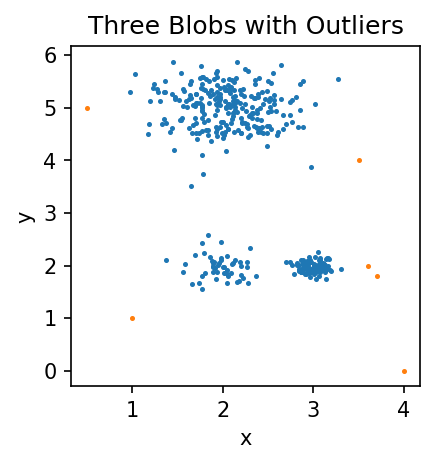

In [3]:
sim_data = make_blobs(n_samples=[50, 100, 250], n_features=2, centers=[(2,2), (3,2), (2, 5)],
                      cluster_std=[0.2, 0.1, 0.4], random_state=12)

data = pd.DataFrame(sim_data[0])

data["outlier"] = 1
outliers = {0:[1, 4, 3.5, 0.5, 3.6, 3.7], 1:[1, 0, 4, 5, 2, 1.8],
           "outlier":-1}
data = data.append(pd.DataFrame(outliers))
data.columns = ["x","y","outlier"]

fix, ax = plt.subplots(figsize=(3,3), dpi=150)
plt.scatter(x="x", y="y", data=data[data.outlier==1], s=2)
plt.scatter(x="x", y="y", data=data[data.outlier==-1], s=2)
ax.set_xlabel("x")
ax.set_ylabel("y")


plt.title("Three Blobs with Outliers")

# Local Outlier Factor
Here we quickly verify that the local outlier factor method will work as intended.

In [4]:
clf = LocalOutlierFactor(n_neighbors=50, contamination="auto")
X = data.loc[:,("x","y")].values
y_pred = clf.fit_predict(X)
data["lof_class"] = y_pred
data["lof"] = np.abs(clf.negative_outlier_factor_)
data.head()

,x,y,outlier,lof_class,lof
0,2.435101,4.640673,1,1,1.044350
1,1.435299,5.273166,1,1,1.169545
2,1.024900,5.648835,1,-1,1.862570
3,2.306930,5.229041,1,1,1.014627
4,1.697930,5.260673,1,1,1.005531


In [5]:
from sklearn.metrics import confusion_matrix

confusion_matrix(data.outlier, data.lof_class)

array([[  6,   0],
       [ 18, 382]])

Text(0.5, 1.0, 'LOF classified outliers more aggressively')

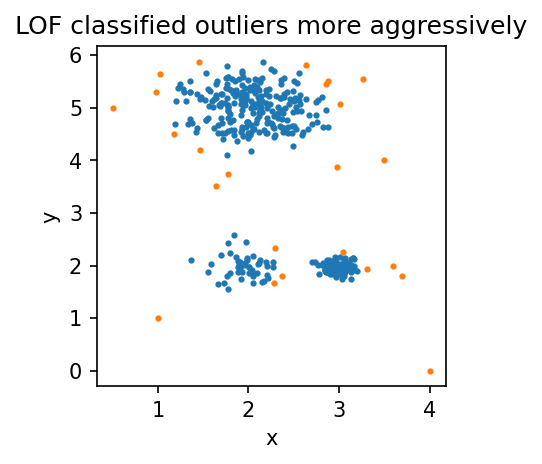

In [6]:
ix, ax = plt.subplots(figsize=(3,3), dpi=150)
plt.scatter(x="x", y="y", data=data[data.lof_class==1], s=4)
plt.scatter(x="x", y="y", data=data[data.lof_class==-1], s=4)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.title("LOF classified outliers more aggressively")

# Results for Different Numbers of Neighbors

In [7]:
# Prepare range of k
X = data.loc[:,("x","y")].values
outclass = []

for i in range(5, 205, 5):
    clf = LocalOutlierFactor(n_neighbors=i, contamination="auto")
    y_pred = clf.fit_predict(X)
    score = clf.negative_outlier_factor_
    radius = (score.max() - score) / (score.max() - score.min())
    outclass += [np.array([y_pred, [i]*len(y_pred), score, radius]).T]

In [8]:
id = np.arange(1,len(X)+1,1)
df = pd.DataFrame(np.concatenate(outclass), columns = ("outlier_pred", "neighbors",
                                                       "lof", "radius"))
df["outlier_pred_n"] = np.where(df["outlier_pred"]==1, "Not an Outlier", "Outlier")
coords = pd.DataFrame(np.tile(X, (40,1)), columns=("x","y"))
df_interact = pd.concat([coords,df], axis=1)
df_interact["uid"] = np.tile(id, 40)

In [9]:
df_interact

,x,y,outlier_pred,neighbors,lof,radius,outlier_pred_n,uid
0,2.435101,4.640673,1.0,5.0,-1.066270,0.015062,Not an Outlier,1
1,1.435299,5.273166,1.0,5.0,-1.071748,0.015547,Not an Outlier,2
2,1.024900,5.648835,-1.0,5.0,-1.864578,0.085715,Outlier,3
3,2.306930,5.229041,1.0,5.0,-1.021006,0.011056,Not an Outlier,4
4,1.697930,5.260673,1.0,5.0,-0.989475,0.008265,Not an Outlier,5
...,...,...,...,...,...,...,...,...
16235,4.000000,0.000000,-1.0,200.0,-1.726692,0.954000,Outlier,402
16236,3.500000,4.000000,-1.0,200.0,-1.762918,1.000000,Outlier,403
16237,0.500000,5.000000,-1.0,200.0,-1.618258,0.816309,Outlier,404
16238,3.600000,2.000000,1.0,200.0,-1.460512,0.616001,Not an Outlier,405


In [10]:
df_interact[df_interact.x==0]

,x,y,outlier_pred,neighbors,lof,radius,outlier_pred_n,uid


# Interactive Figure with Plotly

In [11]:
fig = px.scatter(df_interact, x="x", y="y",  
                 color="outlier_pred_n",
                 animation_frame="neighbors",
                 animation_group="uid",
                 title="<b>Local Outlier Factor with Simulated Data</b>",
                 size = "radius",
                 size_max=40,
                 symbol_sequence=["circle-open-dot"],
                 labels={
                     "x": "X",
                     "y": "Y",
                     "outlier_pred_n": "Outlier Status",
                     "neighbors": "Number of Neighbors"
                 })

fig["layout"].pop("updatemenus")
fig.update_traces(marker={"line":{"width":2}})
fig.update_xaxes(range=[-0.25, 5])
fig.update_yaxes(range=[-1, 6])

fig.update_layout(
    title={
        'font':{'size':18},
        'text': "Outlier Classification Depends on Number of Neighbors",
        'y':0.95,
        'x':0.355,
        'xanchor': 'center',
        'yanchor': 'top'},
    margin=dict(l=50, r=50, t=50, b=10),
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
)
)
fig['layout']['sliders'][0]['pad']=dict(l=-50, r=0, b=0, t=20)

fig.update_layout(
    autosize=False,
    width=800, height=600,
    font_family="Iosevka Term",
    font_color="black",
    title_font_family="Roboto Slab",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.show("iframe")
#fig.show("browser")

In [12]:
df["radius"].max()

1.0

In [13]:
report = dp.Report(dp.Plot(fig, name="neighbors", responsive=False) ) #Create a report
report.upload(name='datapane_test', open=True) #Publish the report

Publishing document and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Your report doesn't contain any text - consider using TextReport to upload assets and add text to your report from your browser

Report successfully uploaded, click [here](https://datapane.com/u/daniel70/reports/datapane-test/) to view your report and optionally share it with the Datapane Community

# Faceted Plot

Text(0.5, 1.0, 'One Blob with Outliers')

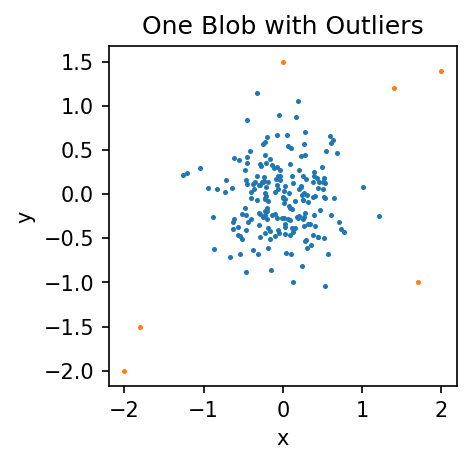

In [14]:
data_1 = make_blobs(n_samples=[200], n_features=2, centers=[(0,0)],
                      cluster_std=0.4, random_state=12)
data_1 = pd.DataFrame(data_1[0])
data_1["outlier"] = 1
outliers = {0:[-2, 1.7, 1.4, -1.8, 2, 0], 1:[-2, -1, 1.2, -1.5, 1.4, 1.5],
           "outlier":-1}
data_1 = data_1.append(pd.DataFrame(outliers))
data_1.columns = ["x","y","outlier"]


fix, ax = plt.subplots(figsize=(3,3), dpi=150)
plt.scatter(x="x", y="y", data=data_1[data_1.outlier==1], s=2)
plt.scatter(x="x", y="y", data=data_1[data_1.outlier==-1], s=2)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.title("One Blob with Outliers")

Text(0.5, 1.0, 'Two Blobs with Outliers')

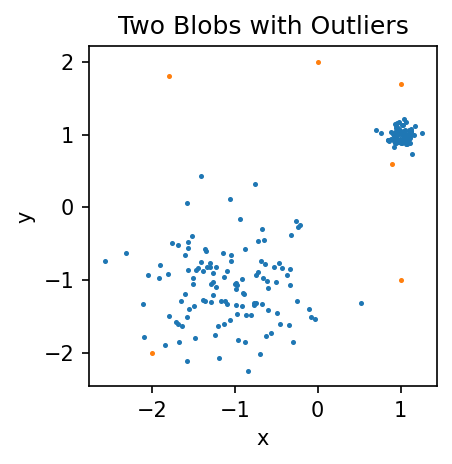

In [15]:
data_2 = make_blobs(n_samples=[120, 80], n_features=2, centers=[(-1,-1), (1, 1)],
                      cluster_std=[0.5, 0.1], random_state=12)
data_2 = pd.DataFrame(data_2[0])
data_2["outlier"] = 1
outliers = {0:[-2, 1, 0, -1.8, 1, 0.9], 1:[-2, -1, 2, 1.8, 1.7, 0.6],
           "outlier":-1}
data_2 = data_2.append(pd.DataFrame(outliers))
data_2.columns = ["x","y","outlier"]

fix, ax = plt.subplots(figsize=(3,3), dpi=150)
plt.scatter(x="x", y="y", data=data_2[data_2.outlier==1], s=2)
plt.scatter(x="x", y="y", data=data_2[data_2.outlier==-1], s=2)
ax.set_xlabel("x")
ax.set_ylabel("y")
plt.title("Two Blobs with Outliers")

In [16]:
# Prepare range of k
X = data_1.loc[:,("x","y")].values
outclass = []

for i in range(5, 205, 5):
    clf = LocalOutlierFactor(n_neighbors=i, contamination="auto")
    y_pred = clf.fit_predict(X)
    score = clf.negative_outlier_factor_
    radius = (score.max() - score) / (score.max() - score.min())
    outclass += [np.array([y_pred, [i]*len(y_pred), score, radius]).T]
    
id = np.arange(1,len(X)+1,1)
df_1 = pd.DataFrame(np.concatenate(outclass), columns = ("outlier_pred", "neighbors",
                                                       "lof", "radius"))
df_1["outlier_pred_n"] = np.where(df_1["outlier_pred"]==1, "Not an Outlier", "Outlier")
coords = pd.DataFrame(np.tile(X, (40,1)), columns=("x","y"))
df_interact_1 = pd.concat([coords,df_1], axis=1)
df_interact_1["uid"] = np.tile(id, 40)
df_interact_1['centers'] = "One Center"

# ------------------------------------

X = data_2.loc[:,("x","y")].values
outclass = []

for i in range(5, 205, 5):
    clf = LocalOutlierFactor(n_neighbors=i, contamination="auto")
    y_pred = clf.fit_predict(X)
    score = clf.negative_outlier_factor_
    radius = (score.max() - score) / (score.max() - score.min())
    outclass += [np.array([y_pred, [i]*len(y_pred), score, radius]).T]
    
id = np.arange(len(X)+1,2*len(X)+1,1)
df_2 = pd.DataFrame(np.concatenate(outclass), columns = ("outlier_pred", "neighbors",
                                                       "lof", "radius"))
df_2["outlier_pred_n"] = np.where(df_1["outlier_pred"]==1, "Not an Outlier", "Outlier")
coords = pd.DataFrame(np.tile(X, (40,1)), columns=("x","y"))
df_interact_2 = pd.concat([coords,df_2], axis=1)
df_interact_2["uid"] = np.tile(id, 40)
df_interact_2['centers'] = "Two Centers"



df_viz = pd.concat([df_interact_1, df_interact_2])

In [61]:
from PIL import Image; img = Image.open('/Users/danielliden/Downloads/Union.png')
img2 = Image.open('/Users/danielliden/Downloads/Group 4555.png')

fig = px.scatter(df_viz, x="x", y="y",  
                 color="outlier_pred_n",
                 animation_frame="neighbors",
                 animation_group="uid",
                 title="<b>Local Outlier Factor with Simulated Data</b>",
                 size = "radius",
                 size_max=40,
                 symbol_sequence=["circle-open-dot"],
                 color_discrete_sequence=[BLUE, RED],
                 facet_col = "centers",
                 labels={
                     "x": "X",
                     "y": "Y",
                     "outlier_pred_n": "Outlier Status",
                     "neighbors": "Number of Neighbors",
                 "radius": "radius"},
                hover_data = {"radius":False,
                             "centers":False})
fig.for_each_annotation(lambda a: a.update(text=a.text.replace("centers=", "")))
fig["layout"].pop("updatemenus")
fig.update_traces(marker={"line":{"width":2}})
fig.update_xaxes(range=[-2.5, 2.5])
fig.update_yaxes(range=[-2.5, 3])

fig.update_layout(
    title={
        'font':{'size':16},
        'text': "Outlier Detection with LOF<br>Depends on Number of Neighbors",
        'y':0.97,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'},
    margin=dict(l=50, r=50, t=50, b=10),
    legend=dict(
    yanchor="top",
    y=0.99,
    xanchor="right",
    x=0.99
)
)

fig.add_annotation(x=0, y=-1.5,
            text="<b>Cluster 1:</b><br>Center: (0,0)<br>N=200<br>SD: 0.4",
            showarrow=False)

fig.add_annotation(x=-1, y=0.5, xref="x2",
            text="<b>Cluster 1</b> :<br>Center: (-1,-1))<br>N=120<br>SD: 0.5",
            showarrow=False)

fig.add_annotation(x=1, y=0.1, xref="x2",
            text="<b>Cluster 2</b>:<br>Center: (1,1))<br>N=80<br>SD: 0.1",
            showarrow=False)


fig.add_annotation(x=0, y=0.98, xref="paper", yref="paper",
            text="Circle radii are proportional to Local Outlier Factor score",
            showarrow=False, align="left", )

fig['layout']['sliders'][0]['pad']=dict(l=-50, r=120, b=0, t=20)

fig.update_layout(
    autosize=False,
    width=900, height=600,
    font_family="Inter",
    font_color="black",
    title_font_family="Comfortaa",
    title_font_color="black",
    legend_title_font_color="black"
)

fig.add_layout_image(
    dict(
        source=img,
        xref="paper", yref="paper",
        x=1, y=1.025,
        sizex=.12, sizey=.12,
        xanchor="right", yanchor="bottom"
    )
)

fig.add_layout_image(
    dict(
        source=img2,
        xref="paper", yref="paper",
        x=1, y=-.18,
        sizex=.12, sizey=.12,
        xanchor="right", yanchor="bottom"
    )
)
fig.show("iframe")
#fig.show("browser")

In [62]:
report = dp.Report(dp.Plot(fig, name="neighbors", responsive=False) ) #Create a report
report.upload(name='lof_neighbors', open=True) #Publish the report

Publishing document and associated data - *please wait...*

Your report only contains a single element - did you know you can include additional plots, tables and text in a report? Check out [the docs](https://docs.datapane.com/reports/blocks/layout-pages-and-selects) for more info

Your report doesn't contain any text - consider using TextReport to upload assets and add text to your report from your browser

Report successfully uploaded, click [here](https://datapane.com/u/daniel70/reports/lof-neighbors/) to view your report and optionally share it with the Datapane Community